In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
feature_dfs = [pd.read_csv(f'output/feat_df_{str(i)}').drop('Unnamed: 0', axis=1) for i in range(6)]
combined_feats = pd.read_csv('output/combined_feats').drop('Unnamed: 0', axis=1)
train_scores = pd.read_csv('input/train_scores.csv')

In [42]:
models = [
    # {
    #     'df': 0,
    #     'model': XGBRegressor(learning_rate=.03, max_depth=3, n_estimators=100, subsample=.65),
    #     'name': 'Pattern Info (XGBRegressor)'
    # },
    {
        'df': 1,
        'model': LGBMRegressor(learning_rate=.1, max_depth=2, n_estimators=200, subsample=.5, num_leaves=131072),
        'name': 'N-gram Td-idf (LGBMRegressor)'
    },
    {
        'df': 2,
        'model': GradientBoostingRegressor(max_depth=2, n_estimators=100, subsample=.65),
        'name': 'Iki Info (GradientBoostingRegressor)'
    },
    {
        'df': 3,
        'model': LinearRegression(),
        'name': 'Aggregate Info (Ridge)'
    },
    # {
    #     'df': 4,
    #     'model': GradientBoostingRegressor(max_depth=3, n_estimators=100, subsample=.8),
    #     'name': 'Other Count Info (GradientBoostingRegressor)'
    # },
    {
        'df': 5,
        'model': XGBRegressor(learning_rate=.03, max_depth=2, n_estimators=200, subsample=.5),
        'name': 'Gap Info (XGBRegressor)'
    },
]
combined_feat_models = [
    {
        'model': LinearRegression(),
        'name': 'LinearRegression'
    },
    # {
    #     'model': SVR(),
    #     'name': 'SVR'
    # },
    # {
    #     'model': KNeighborsRegressor(n_neighbors=10),
    #     'name': 'KNN'
    # },
    {
        'model': GradientBoostingRegressor(max_depth=3, subsample=.7, n_estimators=200),
        'name': 'GBR'
    },
    # {
    #     'model': LGBMRegressor(learning_rate=0.03, max_depth=3, n_estimators=200, num_leaves=131072, subsample=0.5),
    #     'name': 'LGBM'
    # },
    {
        'model': XGBRegressor(learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.4),
        'name': 'XGB'
    }
]

In [31]:
def graph_weights(y_valid_pred1, y_valid_pred2, y_valid_actual, color='blue'):
    weights = np.arange(0, 1.01, .01)
    scores = []
    for w in weights:
        scores.append(mean_squared_error(y_valid_actual, y_valid_pred1 * w + y_valid_pred2 * (1 - w), squared=False))
    print(f'best score: {round(min(scores), 3)}, best weight: {round(weights[scores.index(min(scores))], 3)}')
    plt.figure(figsize=(7, 1.5))
    plt.ylim((.5, .7))
    plt.scatter(weights, scores, s=3, c=color)
    return weights[scores.index(min(scores))]

xgb score: 0.619
ensemble score: 0.611
updated ensemble score: 0.61
xgb score: 0.62
ensemble score: 0.611
updated ensemble score: 0.612
xgb score: 0.62
ensemble score: 0.614
updated ensemble score: 0.615
xgb score: 0.627
ensemble score: 0.621
updated ensemble score: 0.62
xgb score: 0.595
ensemble score: 0.59
updated ensemble score: 0.59
xgb score: 0.595
ensemble score: 0.586
updated ensemble score: 0.586
xgb score: 0.621
ensemble score: 0.664
updated ensemble score: 0.651
xgb score: 0.616
ensemble score: 0.61
updated ensemble score: 0.61
xgb score: 0.645
ensemble score: 0.635
updated ensemble score: 0.636
xgb score: 0.605
ensemble score: 0.597
updated ensemble score: 0.599
xgb score: 0.589
ensemble score: 0.628
updated ensemble score: 0.614
xgb score: 0.59
ensemble score: 0.583
updated ensemble score: 0.584
xgb score: 0.611
ensemble score: 0.608
updated ensemble score: 0.605
xgb score: 0.607
ensemble score: 0.603
updated ensemble score: 0.602
xgb score: 0.594
ensemble score: 0.591
upda

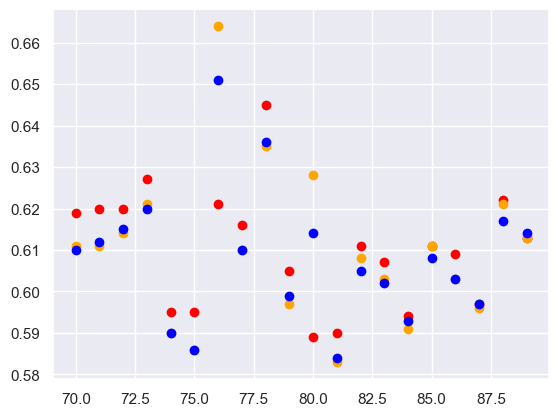

In [43]:
# Step 1: agg info * .61 + gap info * .39
# Step 2: ens * .79 + n-gram * .21
weights = []
xgb_scores = []
ensemble1_scores = []
ensemble2_scores = []
for rs in range(70, 90):
    valid_predicts = {}
    X, y = combined_feats, train_scores['score']
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=rs)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=rs)
    for unit in combined_feat_models:
        # scaler = []
        # if unit['name'] =='KNN':
        #     scaler = StandardScaler()
        #     scaler.fit(X_train)
        # X_train_ = scaler.transform(X_train) if unit['name'] == 'KNN' else X_train
        # X_valid_ = scaler.transform(X_valid) if unit['name'] == 'KNN' else X_valid
        # if unit['name'] == 'LGBM':
        #     X_train_ = X_train_.set_axis([str(i) for i in range(X_train_.shape[1])], axis=1)
        #     X_valid_ = X_valid_.set_axis([str(i) for i in range(X_valid_.shape[1])], axis=1)
        model = unit['model']
        model.fit(X_train, y_train)
        y_predict_train = model.predict(X_train)
        y_predict_valid = model.predict(X_valid)
        valid_predicts[unit['name']] = y_predict_valid
        train_score = round(mean_squared_error(y_train, y_predict_train, squared=False), 3)
        valid_score = round(mean_squared_error(y_valid, y_predict_valid, squared=False), 3)
        # print(f'validation score for model: {unit["name"]} -- {valid_score}')
    xgb_scores.append(round(mean_squared_error(y_valid, valid_predicts['XGB'], squared=False), 3))
    print(f'xgb score: {round(mean_squared_error(y_valid, valid_predicts["XGB"], squared=False), 3)}')
    ensemble = valid_predicts['XGB'] * .79 + valid_predicts['LinearRegression'] * .21
    sc = round(mean_squared_error(y_valid, ensemble, squared=False), 3)
    ensemble1_scores.append(sc)
    print(f'ensemble score: {sc}')
    ensemble = ensemble * .84 + valid_predicts['GBR'] * .16
    sc = round(mean_squared_error(y_valid, ensemble, squared=False), 3)
    ensemble2_scores.append(sc)
    print(f'updated ensemble score: {sc}')
#     w = graph_weights(ensemble, valid_predicts['GBR'], y_valid)
#     weights.append(w)
# print(f'Best weight: {np.mean(weights)}')
plt.scatter(range(70, 90), xgb_scores, c='red')
plt.scatter(range(70, 90), ensemble1_scores, c='orange')
plt.scatter(range(70, 90), ensemble2_scores, c='blue')
print(f'XGB average: {np.mean(xgb_scores)}')
print(f'Ensemble1 average: {np.mean(ensemble1_scores)}')
print(f'Ensemble2 average: {np.mean(ensemble2_scores)}')

In [41]:
from sklearn.model_selection import GridSearchCV

X, y = combined_feats, train_scores['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=rs)

params = {'n_estimators': [50, 100, 200, 500],  
              'max_depth': [2, 3, 5], 
             'subsample': [.7, .8, .9, 1]} 
model = GradientBoostingRegressor()
gs = GridSearchCV(estimator=model, 
                           param_grid=params,
                           scoring='neg_root_mean_squared_error',
                           verbose=2,
                           cv=6)
gs.fit(X_train, y_train)
results = gs.cv_results_
print('Best Score:', round(-gs.best_score_, 3), 'Best Params:', gs.best_params_)

Fitting 6 folds for each of 48 candidates, totalling 288 fits


[CV] END ........max_depth=2, n_estimators=50, subsample=0.7; total time=   3.5s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.7; total time=   2.7s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.7; total time=   2.9s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.7; total time=   2.8s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.7; total time=   2.7s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.7; total time=   2.8s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.8; total time=   3.1s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.8; total time=   3.0s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.8; total time=   3.0s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.8; total time=   3.3s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.8; total time=   3.1s
[CV] END ........max_depth=2, n_estimators=50, subsample=0.8; total time=   3.1s
[CV] END ........max_depth=2